<a href="https://colab.research.google.com/github/baiyunming/I2DL-WS2020/blob/main/%E2%80%9CLecture3_Linear_Regression_ipynb%E2%80%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages

In [2]:
import os
import pickle

# To see the progress
from tqdm.notebook import tqdm

import numpy as np

# For visualization
import matplotlib.pyplot as plt

# Things related to the pytorch
import torch                                        # main pytorch package
import torch.nn as nn                               # pytorch module for neural network
from torch.utils.data import Dataset, DataLoader    # pytorch utils for dataset

# Make the dataset! add noise to the linear function
- gt_w, gt_b : ground truth weight and bias for linear regression
- x : random points
- y : gt_w * x + gt_b + (gaussian) noise

In [3]:
### make the linear dataset. Define the gt_w and gt_b as you want
gt_w = 4.0
gt_b = -2.0

### define the number of data, and value of noise to add to wx+b.
num_data = 1000
noise_value = 2

### Sample some random X between range -1~1 / or range you want..
x_range = np.array([-1, 1])
x = np.linspace(x_range[0], x_range[1], num_data)

### Define some noise to add to wx+b
noise = noise_value * np.random.randn(num_data)
y = gt_w * x + gt_b + noise

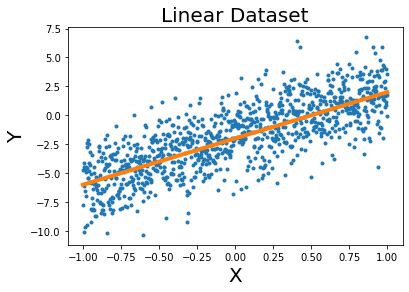

In [4]:
### Plot the dataset
 
plt.plot(x, y, '.')

### Plot the ground truth linear regressor
plt.plot(x_range, x_range * gt_w + gt_b, linewidth=4)

### Title and extras
plt.title('Linear Dataset', fontsize=20)
plt.xlabel('X', fontsize=20)
plt.ylabel('Y', fontsize=20)
plt.show()

# Define the Pytorch Dataset with x y points
- Define your own class, which inherits from "Dataset" class of pytorch
- Define constructor of the class with init
- Define the length of the dataset with len
- Define the function when bringing out the idx-th dataset
    * Return the dictionary containing the input and output of single datapoint


In [5]:
class XY_Dataset(Dataset):
    def __init__(self, x, y):
        '''
        x : input points
        y : output points
        '''
        self.x = x 
        self.y = y 
        self.num_data = x.shape[0]
        pass

    def __len__(self):
        return self.num_data 

    def __getitem__(self, idx):
        sample = dict()
        sample['input'] = self.x[idx]
        sample['output'] = self.y[idx]  
        return sample

# Define the dataset, and dataloader
- DataLoader makes you to randomly sample the dataset with a batch size you want.

In [6]:
### Define the batch size you want
batch_size = 64

### Create the instance of dataset, and dataloader
dataset = XY_Dataset(x,y)
print(len(dataset))
print(dataset[0])

dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=True)

### Try sampling out one random data point.
sample = next(iter(dataloader))
print(sample)

1000
{'input': -1.0, 'output': -4.737480822402923}
{'input': tensor([-1.0000, -0.0010,  0.4875, -0.4014, -0.4194,  0.7317, -0.8719,  0.8418,
         0.3313,  0.8699,  0.7778,  0.3514, -0.0771, -0.8739, -0.7257, -0.4214,
         0.5295, -0.7437, -0.6056, -0.3794, -0.9520, -0.1512, -0.9580,  0.8438,
         0.3614, -0.5115, -0.7097, -0.9399,  0.0150, -0.6717,  0.8078,  0.1011,
        -0.1572, -0.8238,  0.5015, -0.5956, -0.4955,  0.3493, -0.1091, -0.4054,
         0.4775,  0.2412, -0.2032,  0.7237,  0.7618, -0.4555,  0.3133,  0.5556,
         0.5075,  0.8979, -0.1592,  0.7558,  0.7197,  0.1411, -0.2112, -0.6537,
         0.3874,  0.7397, -0.5495,  0.7177, -0.2773,  0.5976, -0.6436,  0.0851],
       dtype=torch.float64), 'output': tensor([-4.7375e+00, -6.6814e-01,  6.3609e-01, -3.4021e+00, -5.0367e+00,
        -8.0984e-01, -3.9852e+00,  3.5457e+00,  4.2367e-02,  2.0312e+00,
         3.4386e-01,  2.5090e+00,  5.0150e-01, -8.1597e+00, -7.7989e+00,
        -5.0111e+00, -1.4364e+00, -8.035

In [7]:
print(sample['input'].shape)
print(sample['input'])  #datloader convert numpy array to tensor 

torch.Size([64])
tensor([-1.0000, -0.0010,  0.4875, -0.4014, -0.4194,  0.7317, -0.8719,  0.8418,
         0.3313,  0.8699,  0.7778,  0.3514, -0.0771, -0.8739, -0.7257, -0.4214,
         0.5295, -0.7437, -0.6056, -0.3794, -0.9520, -0.1512, -0.9580,  0.8438,
         0.3614, -0.5115, -0.7097, -0.9399,  0.0150, -0.6717,  0.8078,  0.1011,
        -0.1572, -0.8238,  0.5015, -0.5956, -0.4955,  0.3493, -0.1091, -0.4054,
         0.4775,  0.2412, -0.2032,  0.7237,  0.7618, -0.4555,  0.3133,  0.5556,
         0.5075,  0.8979, -0.1592,  0.7558,  0.7197,  0.1411, -0.2112, -0.6537,
         0.3874,  0.7397, -0.5495,  0.7177, -0.2773,  0.5976, -0.6436,  0.0851],
       dtype=torch.float64)


# Initialize the weight and bias.

In [8]:
### Needs requires_grad=True, if you want to make as a parameter to train.
#pred_w = torch.FloatTensor(torch.randn(1))
pred_w = torch.rand(1,dtype=torch.float64,requires_grad=True)
pred_b = torch.rand(1,dtype=torch.float64,requires_grad=True)
print('Initialized w: {}, b: {}'.format(pred_w.item(), pred_b.item())) #item get float value
print(pred_w)

Initialized w: 0.4360903819490619, b: 0.6076041728321848
tensor([0.4361], dtype=torch.float64, requires_grad=True)


# Define the ,,train'' function. 

In [9]:
def train(pred_w, pred_b, sample, learning_rate):
    '''
    pred_w : weight to train.
    pred_b : bias to train.
    sample : sample from dataloader. dictionary containing 'x' and 'y'.
    learning_rate : the learning rate you want. 
    pred_loss : predicted loss from this iteration
    '''
    
    # get prediction
    pred_y = pred_w * sample['input'] + pred_b
    
    # calculate the pred_loss
    pred_loss = torch.mean((pred_y - sample['output'])**2)
    
    # make pytorch compute the gradient
    pred_loss.backward()
    #print(pred_w, pred_w.grad)
    #print(pred_b, pred_b.grad)

    # need ``no_grad'' to keep the computed gradient. otherwise, it will generate NoneType
    with torch.no_grad():
        pred_w -= learning_rate * pred_w.grad
        pred_b -= learning_rate * pred_b.grad
        
    # initizlize the gradient to zero
    pred_w.grad.zero_()
    pred_b.grad.zero_()
    
    return pred_loss.item()

In [10]:
train(pred_w,pred_b,sample,learning_rate=0.01)

16.278623063545986

# Iterate over the dataset! With your ,,train'' function

In [11]:
# define the maximum epoch
max_epoch = 1000

# define a list to save the loss
loss_saver = list()

# define how often you will print the result
print_stride = 50

# iterate over the dataset for (max_epoch) times
for epoch in tqdm(range(max_epoch)):
    total_loss = 0.0
    for idx, sample in enumerate(dataloader):
        curr_loss = train(pred_w, pred_b, sample, learning_rate=0.01)
        total_loss += curr_loss / len(dataloader)
    loss_saver.append(total_loss)

    if epoch % print_stride == 0:
      print('loss:{}'.format(total_loss))
print()
print('Final Prediction : pred_w = {}, pred_b = {}'.format(pred_w.item(), pred_b.item()))

loss:12.075880705970814
loss:3.701362732097016
loss:3.6994684025770024
loss:3.7257989494691497
loss:3.6913541678634822
loss:3.6960677663702257
loss:3.7124562142100572
loss:3.7206406670059957
loss:3.7103271870997028
loss:3.688625719525749
loss:3.68325760633114
loss:3.71864450697685
loss:3.6801167189714663
loss:3.6988452532059
loss:3.721381060534931
loss:3.7092088953746254
loss:3.7248543134399212
loss:3.707988974760685
loss:3.69065354125304
loss:3.6944382994314453


Final Prediction : pred_w = 4.05387679625412, pred_b = -1.882416724504617


# Plot the result : training loss and resulted linear regressor

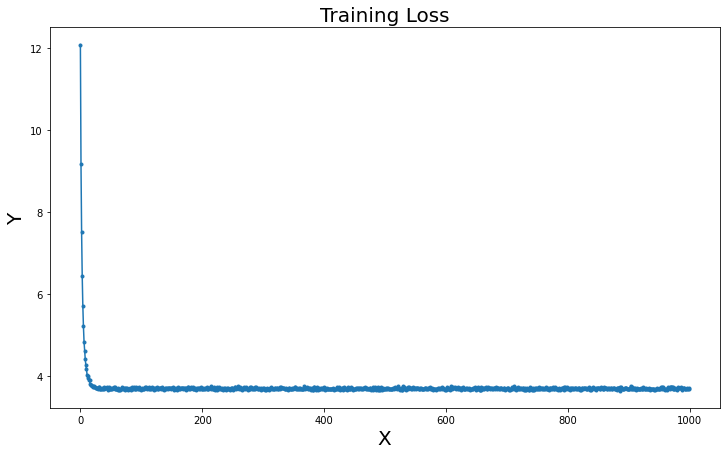

In [12]:
loss_saver = np.array(loss_saver)
plt.figure(figsize=(12, 7))
plt.plot(np.arange(len(loss_saver)), loss_saver, '.-')
plt.title('Training Loss', fontsize=20)
plt.xlabel('X', fontsize=20)
plt.ylabel('Y', fontsize=20)
plt.show()

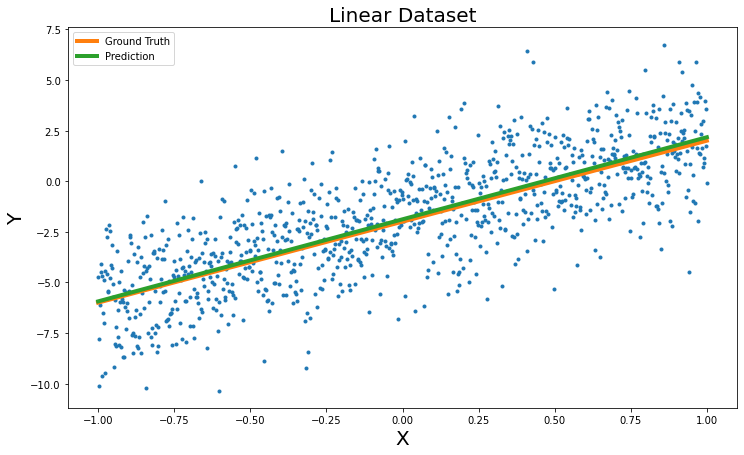

In [13]:
plt.figure(figsize=(12, 7))

### Plot the dataset
plt.plot(x, y, '.')

### Plot the ground truth + predicted linear regressor
plt.plot(x_range, x_range * gt_w + gt_b, linewidth=4, label='Ground Truth')
plt.plot(x_range, x_range * pred_w.item() + pred_b.item(), linewidth=4, label='Prediction')

### Title and extras
plt.title('Linear Dataset', fontsize=20)
plt.xlabel('X', fontsize=20)
plt.ylabel('Y', fontsize=20)
plt.legend()
plt.show()